In [43]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from data_analysis.utils import user
from data.paths.parquet_paths import USER, REVIEW

In [44]:
user_df = pd.read_parquet(str(USER))
review_df = pd.read_parquet(str(REVIEW))

In [45]:
user_df = user.prepare_user_df(user_df)

In [46]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             10000 non-null  object        
 1   name                10000 non-null  object        
 2   review_count        10000 non-null  int32         
 3   yelping_since       10000 non-null  datetime64[ns]
 4   friends             10000 non-null  object        
 5   useful              10000 non-null  int32         
 6   funny               10000 non-null  int32         
 7   cool                10000 non-null  int32         
 8   fans                10000 non-null  int32         
 9   elite               0 non-null      object        
 10  average_stars       10000 non-null  float32       
 11  compliment_hot      10000 non-null  int32         
 12  compliment_more     10000 non-null  int32         
 13  compliment_profile  10000 non-null  int32      

In [47]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float32
 4   date         100000 non-null  object 
 5   text         100000 non-null  object 
 6   useful       100000 non-null  int32  
 7   funny        100000 non-null  int32  
 8   cool         100000 non-null  int32  
dtypes: float32(1), int32(3), object(5)
memory usage: 5.3+ MB


In [48]:
# user_df['user_id'] = user_df['user_id'].astype(str)
# review_df['user_id'] = review_df['user_id'].astype(str)

user_columns = [
    'user_id',
    'name',
    'review_count',
    'yelping_since',
    # 'useful',
    # 'funny',
    # 'cool',
    'fans',
    'average_stars'
]


review_user_df = review_df.join(user_df[user_columns].set_index('user_id'), on='user_id')
review_user_df['date'] = pd.to_datetime(review_user_df['date'])

In [49]:
review_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   review_id      100000 non-null  object        
 1   user_id        100000 non-null  object        
 2   business_id    100000 non-null  object        
 3   stars          100000 non-null  float32       
 4   date           100000 non-null  datetime64[ns]
 5   text           100000 non-null  object        
 6   useful         100000 non-null  int32         
 7   funny          100000 non-null  int32         
 8   cool           100000 non-null  int32         
 9   name           8279 non-null    object        
 10  review_count   8279 non-null    float64       
 11  yelping_since  8279 non-null    datetime64[ns]
 12  fans           8279 non-null    float64       
 13  average_stars  8279 non-null    float32       
dtypes: datetime64[ns](2), float32(2), float64(2), int32(3

In [50]:
review_user_df = review_user_df.loc[~review_user_df['name'].isna()].copy()

In [51]:
review_user_df.sample(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
27115,m-7rn9RWSK4Ep8hjilyPqQ,YMgZqBUAddmFErxLtCfK_w,onTp_aMu3-UOw6w_ySe2ew,4.0,2011-03-23,This was quite possibly the best mani and pedi...,5,0,0,Samantha,1880.0,2009-03-16 23:41:53,169.0,3.64
58799,6N1ChtQAXjyN4cYUyY6M6A,qQecSd0lynfB4g-LPa9JCw,hbZGhzNGWh4VTEmq9a0BKg,5.0,2017-03-06,"For the last year, my child has been attending...",2,1,2,Allison,648.0,2006-02-17 17:24:05,50.0,4.03


<AxesSubplot: >

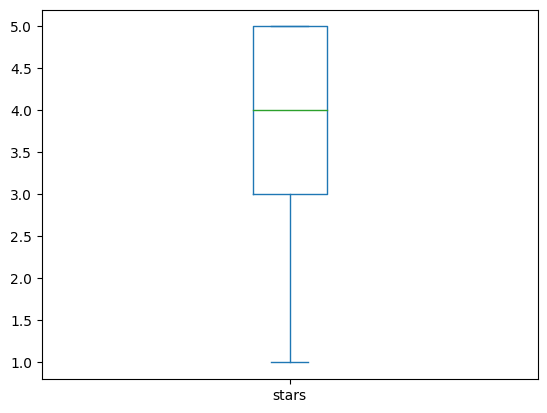

In [52]:
review_user_df.groupby('user_id')['stars'].mean().plot(kind='box')

In [56]:
# early reviews: within month or two after yelping since
youth_threshold = timedelta(days=60)
early_reviews = review_user_df[review_user_df.date - review_user_df.yelping_since < youth_threshold]

early_reviews[['date', 'yelping_since', 'stars', 'user_id']].sample(10)
early_reviews.groupby('user_id').size()

user_id
-28RqJIrddOj9hhMBnzaFA    1
-CJRBwU9PicTdiiSg6nkFA    1
-InhDRRVG7wrwsgAUvN4Qw    3
-NwDw6HgVpA4ys6WYcI6Xg    1
-c_t-8ORqOZBuKE-jdY8aQ    1
                         ..
yoT5mQ0EeB40AAMi4ZIyTw    1
yqV1ri3AFC3rjsfF_rB9bA    1
ywI6YzxkoKyKC2JV4_19Sg    1
z-0oMxk_Xg1mhEAydCJ4KQ    1
zT9WFNJXeQZBA-WJMsV4Zw    5
Length: 558, dtype: int64

In [69]:
review_bursts = review_user_df.groupby(['user_id', 'date']).count()
review_bursts.reset_index(inplace=True)
review_bursts[review_bursts.review_id >= 3]

,user_id,date,review_id,business_id,stars,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars,date_bin
100,-pXs08gJq9ExIk275YLvPg,2008-12-09,4,4,4,4,4,4,4,4,4,4,4,4,4
133,04J_q_VhSBItxNiEAN-gkA,2011-09-26,3,3,3,3,3,3,3,3,3,3,3,3,3
142,06xIElWq6CAvmtk1xHJWNA,2006-01-10,5,5,5,5,5,5,5,5,5,5,5,5,5
449,33v8c5ftrKuDGTw1ZQ2toQ,2013-02-23,3,3,3,3,3,3,3,3,3,3,3,3,3
468,3AV5ONopdwL5qKYW20SRdg,2014-02-09,3,3,3,3,3,3,3,3,3,3,3,3,3
627,4LXaLFib9dOAavCN7gnE_g,2013-10-04,3,3,3,3,3,3,3,3,3,3,3,3,3
735,5Kbn1FjXmS7Jypz3_ybt_Q,2006-01-14,4,4,4,4,4,4,4,4,4,4,4,4,4
795,5snWEoA7Qsu-H7nY4aTpAQ,2015-02-24,3,3,3,3,3,3,3,3,3,3,3,3,3
979,7UBDZmeF101orAc72KeofQ,2009-03-08,3,3,3,3,3,3,3,3,3,3,3,3,3
1183,97TjZvvXtVZY91NEPZXZBQ,2010-01-11,3,3,3,3,3,3,3,3,3,3,3,3,3


In [68]:
# ~14 years * ~50 weeks
bins_count = 700

review_user_df['date_bin'] = pd.cut(review_user_df['date'], bins=bins_count, labels=range(bins_count))
review_bursts_binned = review_user_df.groupby(['user_id', 'date_bin']).count()
review_bursts_binned.reset_index(inplace=True)
review_bursts_binned[review_bursts.review_id >= 3]

,user_id,date_bin,review_id,business_id,stars,date,text,useful,funny,cool,name,review_count,yelping_since,fans,average_stars
295,---1lKK3aKOuomHnwAkAow,295,3,3,3,3,3,3,3,3,3,3,3,3,3
19806,-RhRXVW9z9fs5zzxhFfnHg,206,4,4,4,4,4,4,4,4,4,4,4,4,4
32495,-gQm-IoK2_BMEMx9OgtQnw,295,3,3,3,3,3,3,3,3,3,3,3,3,3
43593,-pXs08gJq9ExIk275YLvPg,193,3,3,3,3,3,3,3,3,3,3,3,3,3
43594,-pXs08gJq9ExIk275YLvPg,194,6,6,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3197095,y0ZU1w6YY4W-KtMeRXSYLg,195,3,3,3,3,3,3,3,3,3,3,3,3,3
3208013,yH3Jyu5vRTAJ8uMAD2bLGQ,613,3,3,3,3,3,3,3,3,3,3,3,3,3
3208306,yH5H3fJrxFXuXyC6LQYacg,206,3,3,3,3,3,3,3,3,3,3,3,3,3
3257279,zT9WFNJXeQZBA-WJMsV4Zw,179,3,3,3,3,3,3,3,3,3,3,3,3,3
